# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-05-02 08:10:18.947161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 08:10:18.947205: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('data.csv')
df.shape[1]

160

#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
y_label = 'SHSeizComaPast12mos' 


In [6]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition

def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [7]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'R

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [11]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3615
1     1.0   3038
2     2.0      2


In [12]:
# only SH event occured 
is_male = True
if is_male:
    gender_label = 1.0
else:
    gender_label = 0.0

df_sh = df[df[y_label]==0.0]
gender_groupby = df_sh.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)
print(df.shape)
df = df[df['Gender'] == gender_label]
df.shape

   Gender  total
0     0.0    106
1     1.0     99
(6655, 158)


(3038, 158)

In [13]:
def remove_gender_specific_fields(df):
    if is_male:
        drop_list = ['Pt_MenarcheAge','Pt_RegMenstCyc','Pt_IrregMenstCycReas','Pt_CurrPreg','Pt_MiscarriageNum']
        df = df.drop(drop_list, axis = 1)
        return df
    else:
        return df

df = remove_gender_specific_fields(df)

# Divide Dataset

In [14]:
df=df.drop('PtID', axis = 1)

In [15]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [16]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872
41,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.5065
43,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,43.0773
46,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.2868
48,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3128
49,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.1355


In [17]:
# plt.figure(figsize=(16, 6))
# mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

# heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [18]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [19]:
Y.unique()

array([1., 0.])

# Feature Selection

In [20]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [21]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)

# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [22]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [  74 2204]
Test -  [0. 1.] [ 25 735]


# Imputations

<AxesSubplot:>

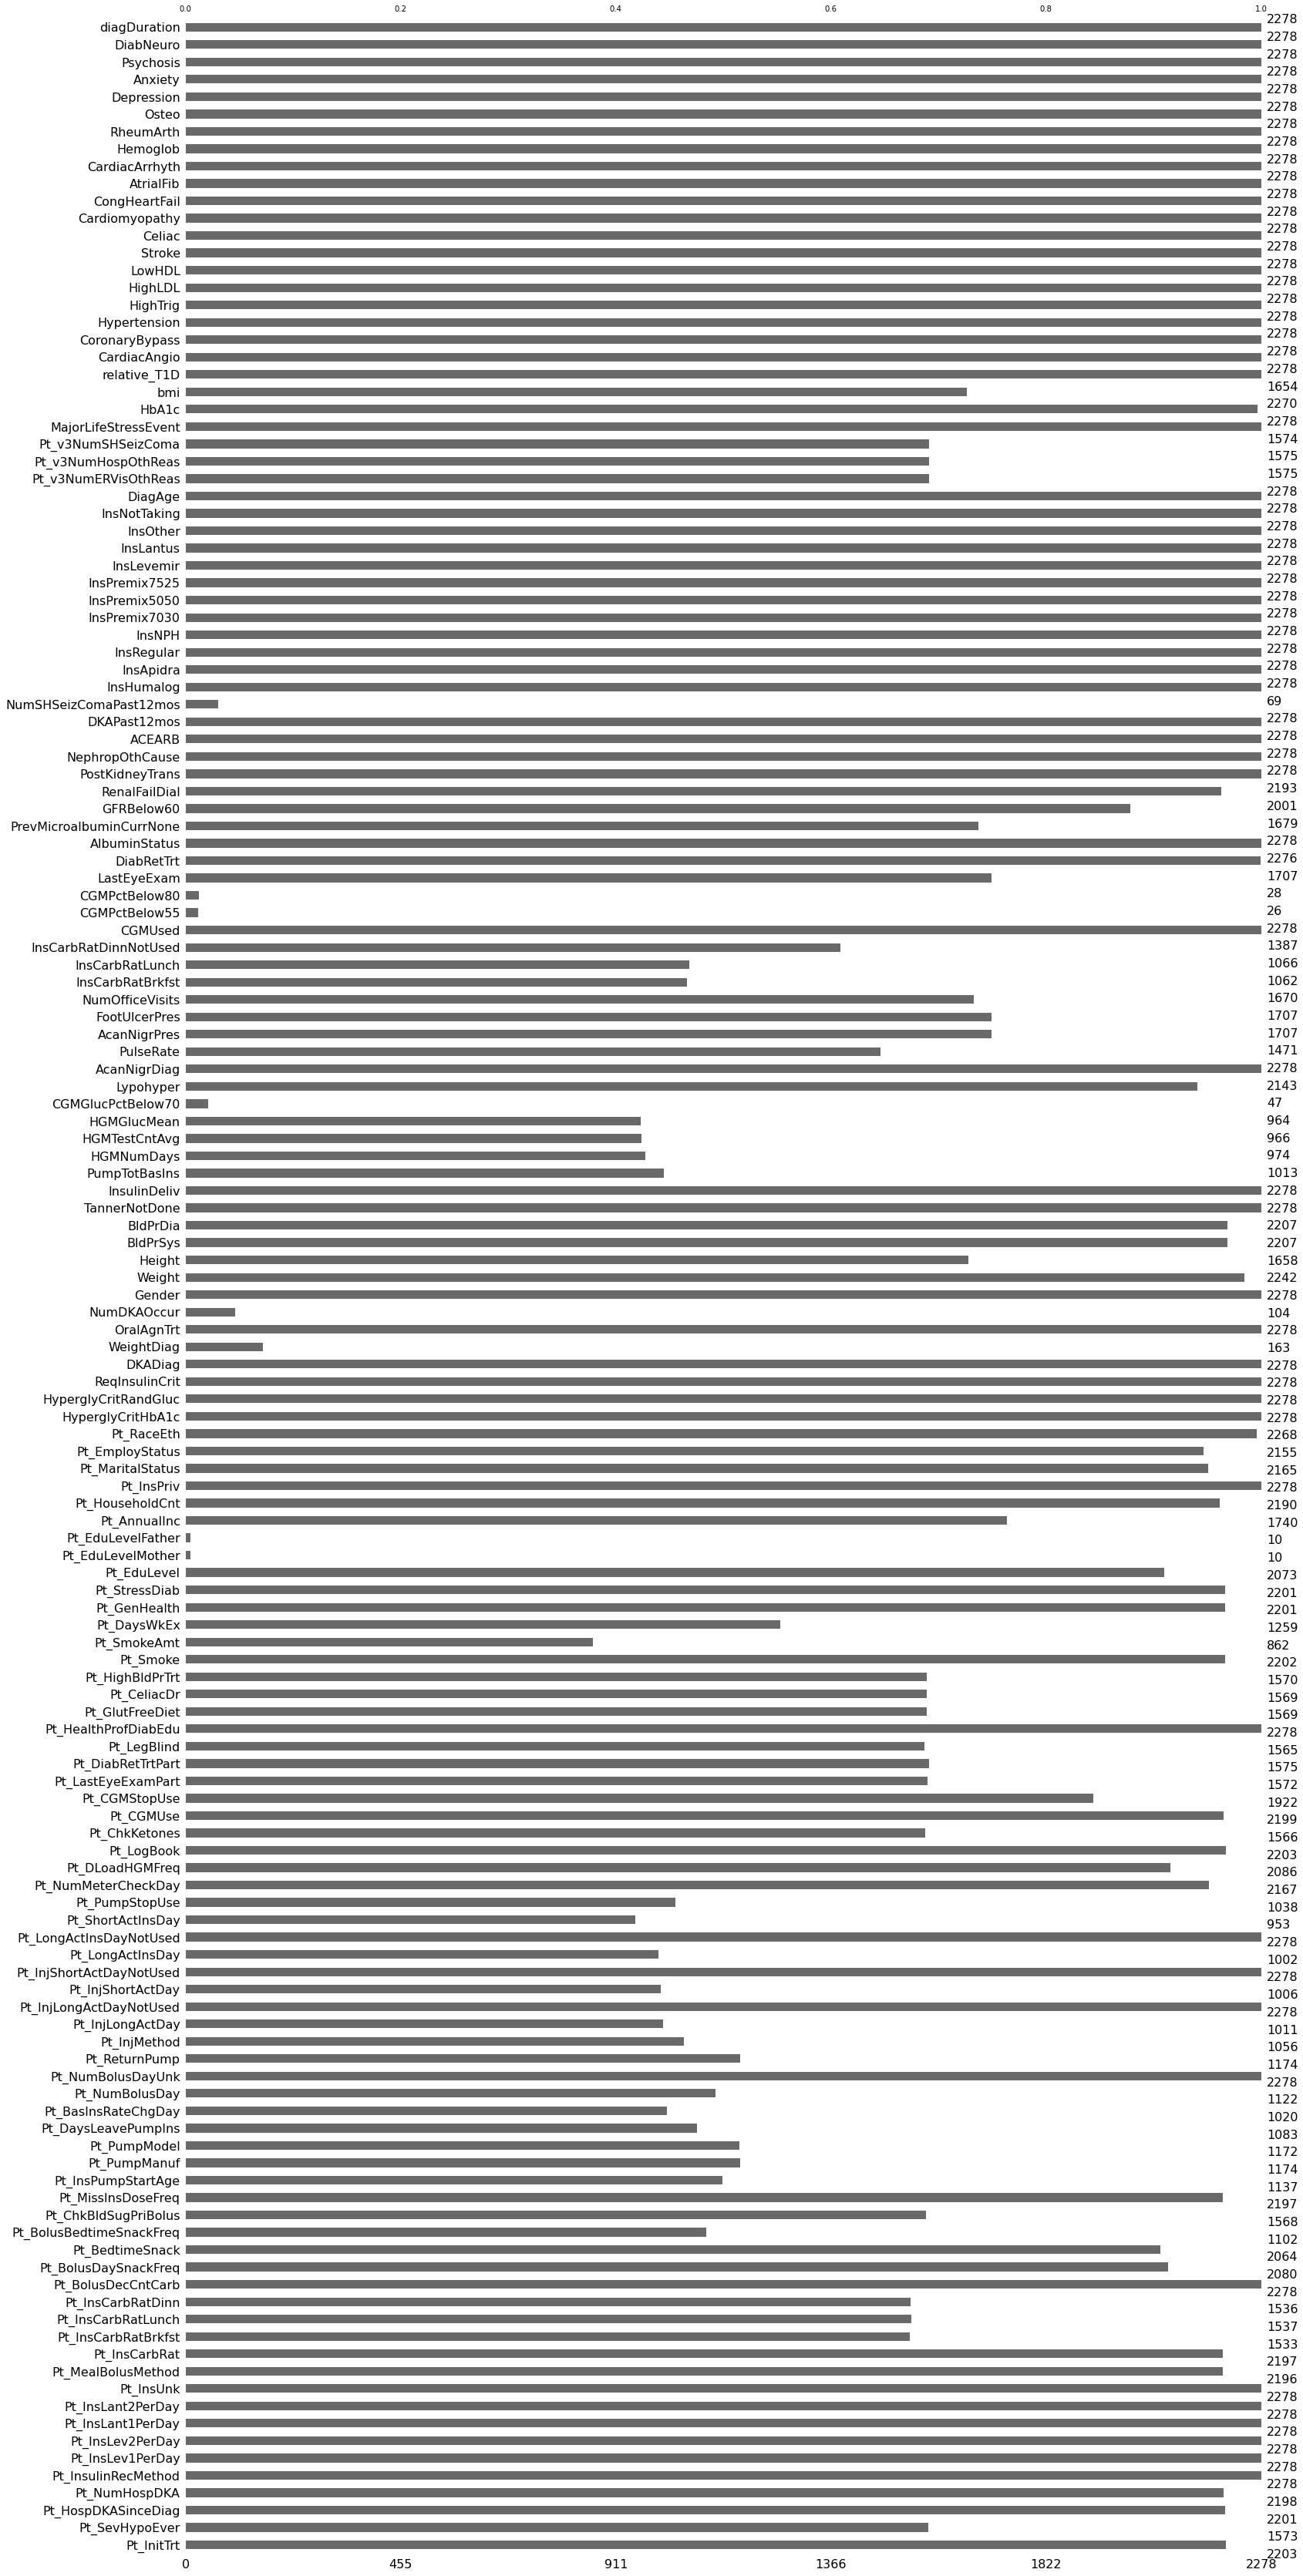

In [23]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [24]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [25]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

feature_list_m = ['Pt_SevHypoEver', 'AcanNigrDiag', 'Pt_BasInsRateChgDay', 'HighLDL',
                  'Pt_CGMUse', 'Pt_v3NumHospOthReas', 'DiabRetTrt', 'FootUlcerPres', 'Pt_LegBlind',
                  'Pt_ChkKetones', 'AcanNigrPres', 'Pt_MissInsDoseFreq', 'InsOther', 'LastEyeExam', 'education_level',
                  'Pt_InjLongActDay', 'Pt_SmokeAmt', 'Pt_GenHealth', 'Pt_InjMethod', 'Pt_HighBldPrTrt',
                  'NumOfficeVisits', 'Pt_DaysWkEx', 'Osteo','Pt_CGMStopUse','Pt_NumBolusDay']

# feature_list = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag',
#        'Pt_InsLev1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsCarbRatDinn',
#        'Pt_PumpManuf', 'Pt_DaysLeavePumpIns', 'Pt_ChkKetones',
#        'Pt_HighBldPrTrt', 'Pt_InsPriv', 'WeightDiag', 'HGMNumDays',
#        'Lypohyper', 'AcanNigrDiag', 'AcanNigrPres', 'NumOfficeVisits',
#        'InsCarbRatLunch', 'LastEyeExam', 'AlbuminStatus', 'RenalFailDial',
#         'CardiacAngio',
#        'diagDuration']
# X_train_copy = X_train_copy[feature_list_m]
# X_test_copy = X_test_copy[feature_list_m]
    

In [26]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1

    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.9671052631578947, doublecheck: 0.9671052631578947
Accuracy for the fold no. 2 on the test set: 0.9671052631578947, doublecheck: 0.9671052631578947
Accuracy for the fold no. 3 on the test set: 0.9671052631578947, doublecheck: 0.9671052631578947
Accuracy for the fold no. 4 on the test set: 0.9692307692307692, doublecheck: 0.9692307692307692
Accuracy for the fold no. 5 on the test set: 0.967032967032967, doublecheck: 0.967032967032967
Cross validation mean accuracy 0.9675159051474841

 
 ===========   Train Dataset    =============
train ROC score 0.950060087310541
Threshold value is: 0.9183991273675808


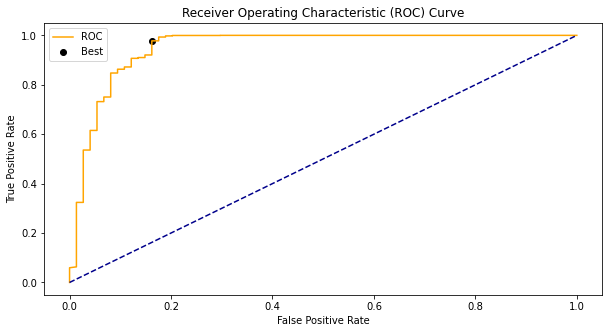

accuracy score:  97.32221246707638
              precision    recall  f1-score   support

         0.0       0.56      0.84      0.67        74
         1.0       0.99      0.98      0.99      2204

    accuracy                           0.97      2278
   macro avg       0.78      0.91      0.83      2278
weighted avg       0.98      0.97      0.98      2278



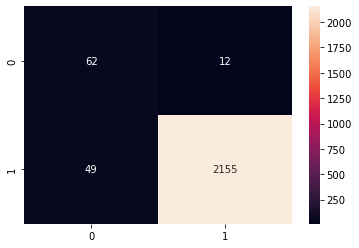



 ===========   Test Dataset    =============
Threshold value is: 0.9713497097793206


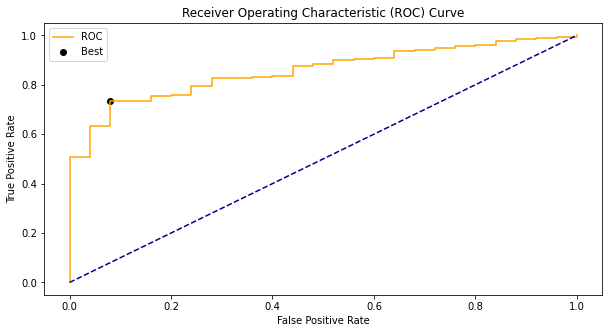

accuracy score:  73.94736842105263
              precision    recall  f1-score   support

         0.0       0.11      0.92      0.19        25
         1.0       1.00      0.73      0.84       735

    accuracy                           0.74       760
   macro avg       0.55      0.83      0.52       760
weighted avg       0.97      0.74      0.82       760



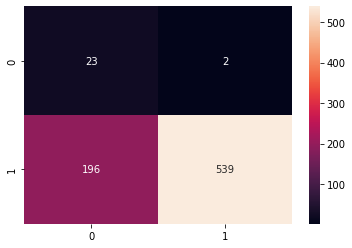



 ===========   ROC    =============
roc_auc = 0.8557


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.92       0.73333333]
balanced accuracy:  0.8266666666666667
f1 0.7394736842105263


In [27]:
# HistGradientBoostingClassifier - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 100,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('balanced accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))

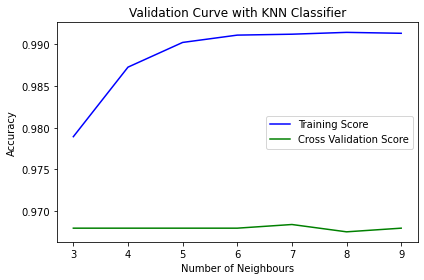

In [28]:
model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
#         max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
        n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
        min_child_weight = 4,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
parameter_range = np.arange(3, 10, 1)
from sklearn.model_selection import validation_curve
train_score, test_score = validation_curve(model, X_train_copy, Y_train,
                                        param_name = "max_depth",
                                        param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

Accuracy for the fold no. 1 on the test set: 0.9671052631578947, doublecheck: 0.9671052631578947
Accuracy for the fold no. 2 on the test set: 0.9670619235836627, doublecheck: 0.9670619235836627
Accuracy for the fold no. 3 on the test set: 0.9670619235836627, doublecheck: 0.9670619235836627
Cross validation mean accuracy 0.9670763701084066

 
 ===========   Train Dataset    =============
train ROC score 0.9246026879874429
Threshold value is: 1.9872924


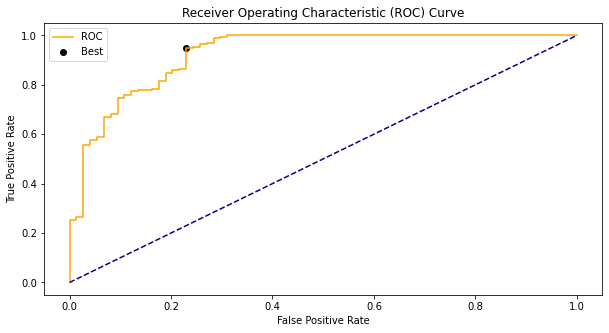

accuracy score:  94.38103599648815
              precision    recall  f1-score   support

         0.0       0.34      0.77      0.47        74
         1.0       0.99      0.95      0.97      2204

    accuracy                           0.94      2278
   macro avg       0.67      0.86      0.72      2278
weighted avg       0.97      0.94      0.95      2278



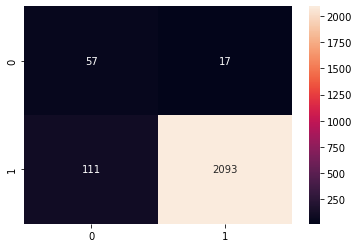



 ===========   Test Dataset    =============
Threshold value is: 2.6049683


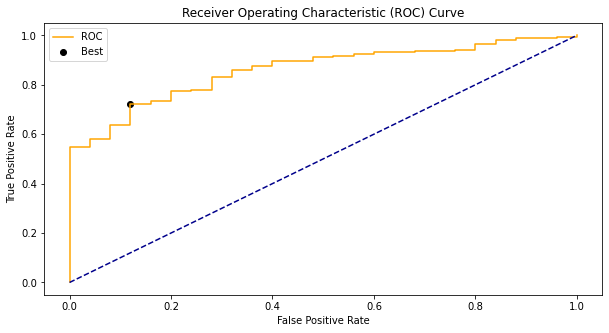

accuracy score:  72.63157894736842
              precision    recall  f1-score   support

         0.0       0.10      0.88      0.17        25
         1.0       0.99      0.72      0.84       735

    accuracy                           0.73       760
   macro avg       0.55      0.80      0.51       760
weighted avg       0.96      0.73      0.81       760



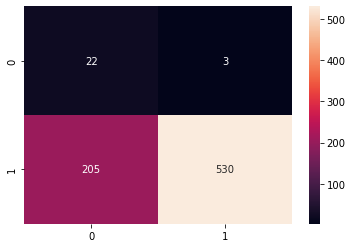



 ===========   ROC    =============
roc_auc = 0.8597


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.88       0.72108844]
balanced accuracy:  0.8005442176870748
f1 0.7263157894736842


In [29]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
        n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
        min_child_weight = 4,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('balanced accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))


<AxesSubplot:>

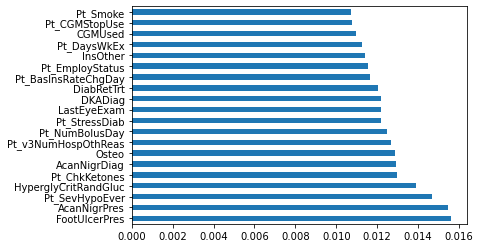

In [30]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

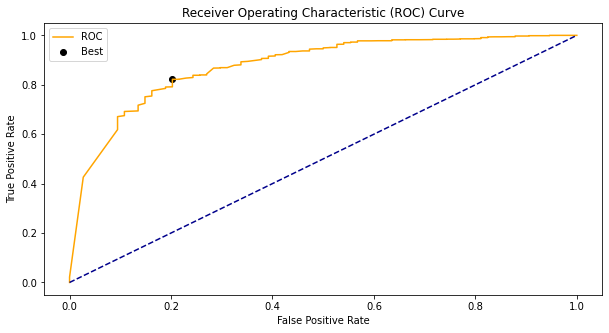

accuracy score:  82.1334503950834
              precision    recall  f1-score   support

         0.0       0.13      0.80      0.22        74
         1.0       0.99      0.82      0.90      2204

    accuracy                           0.82      2278
   macro avg       0.56      0.81      0.56      2278
weighted avg       0.96      0.82      0.88      2278



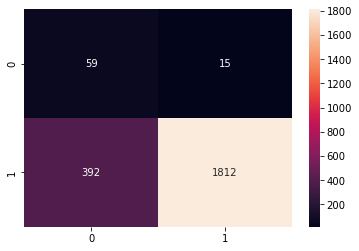



 ===========   Test Dataset    =============
Threshold value is: 0.9840523382685697


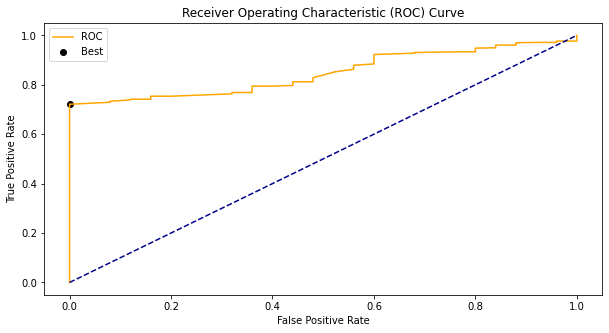

accuracy score:  73.02631578947368
              precision    recall  f1-score   support

         0.0       0.11      1.00      0.20        25
         1.0       1.00      0.72      0.84       735

    accuracy                           0.73       760
   macro avg       0.55      0.86      0.52       760
weighted avg       0.97      0.73      0.82       760



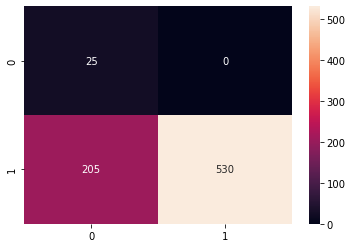



 ===========   ROC    =============
roc_auc = 0.8473


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [1.         0.72108844]
balanced accuracy:  0.8605442176870748
f1 0.7302631578947368


In [27]:
model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01,
                         scale_pos_weight=7,
                         max_depth =3, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()



# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('balanced accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test,  average = 'micro'))

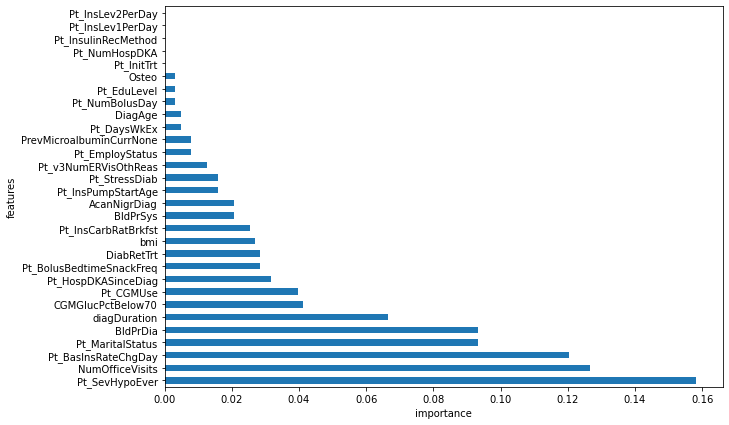

In [28]:
# feature importance graph of XGB
plt.figure(figsize=(10,7))

feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feature_importances = pd.Series((model.feature_importances_ / sum(model.feature_importances_)), index=X_train_copy.columns[0:204])
feature_importances.nlargest(30).plot(kind='barh')
plt.xlabel("importance")
plt.ylabel("features")
plt.savefig('fiSHMale.png', bbox_inches='tight')

In [43]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Actual class - Positive DKA', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Actual class - Negative DKA', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.SHSeizComaPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1, color = 'r')
    plt.axhline(y=thresh2, color = 'g')
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

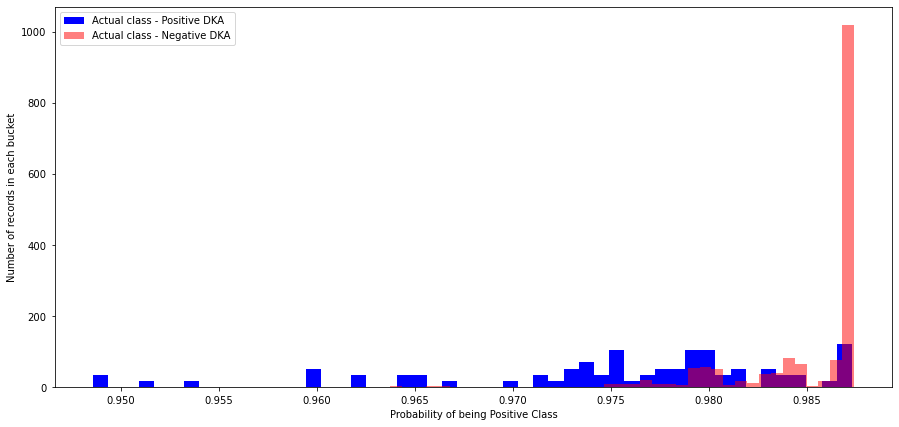

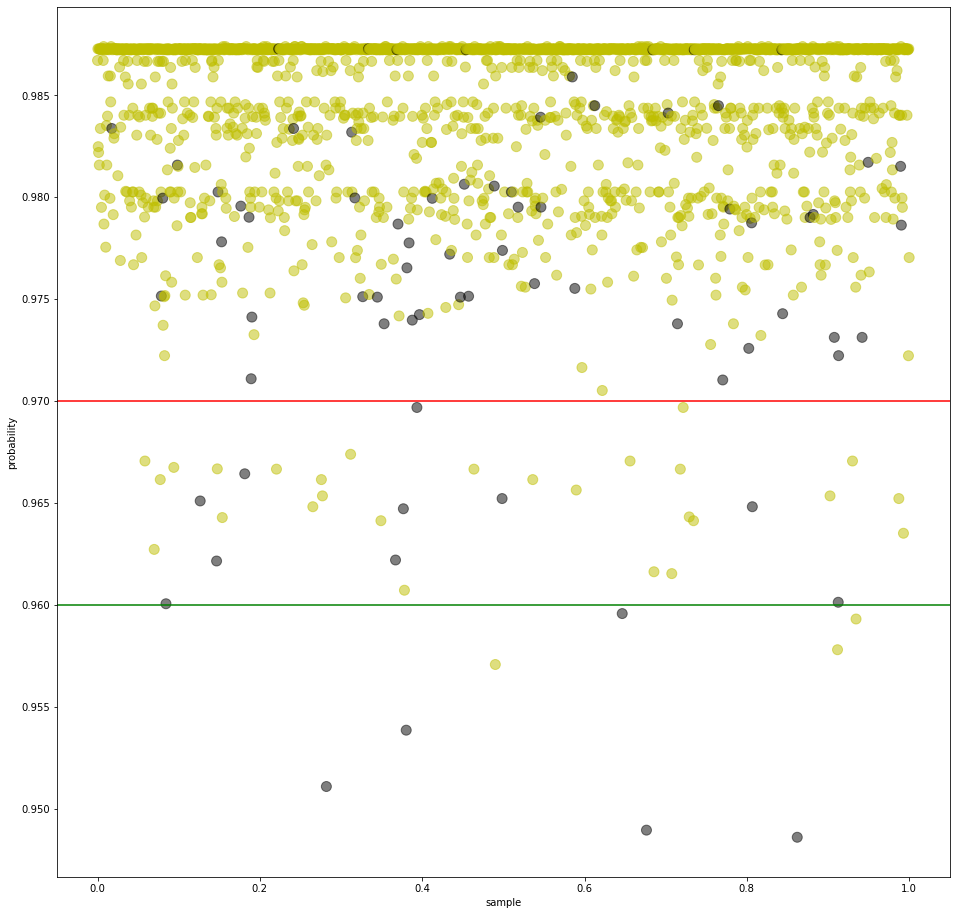

In [44]:
patients_count = X_train_copy.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.85
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(model, X_train_copy, 8000, 200)
thresh2 = 0.96
draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)

In [35]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


predictoin [1]
actial 1.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


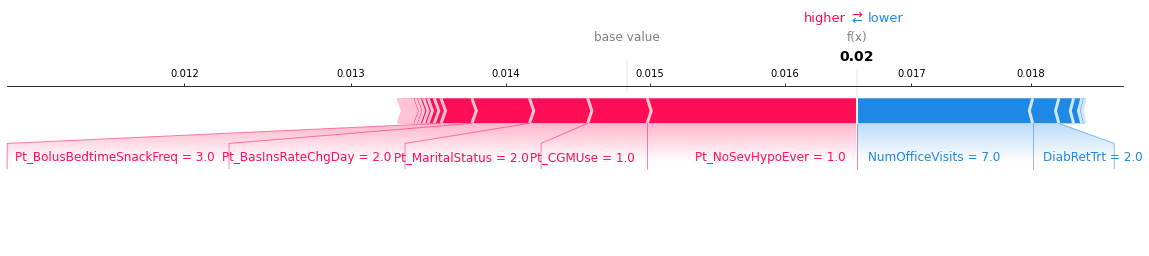

In [39]:
X_test_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)
X_train_copy.rename(columns = {'Pt_SevHypoEver':'Pt_NoSevHypoEver'}, inplace = True)

row_to_show = 94
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
model.predict_proba(data_for_prediction_array)


# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).

import matplotlib.pyplot as pl
shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit', show=False, matplotlib=True)
plt.savefig('SHmalelocalinterpret.png' ,bbox_inches='tight')




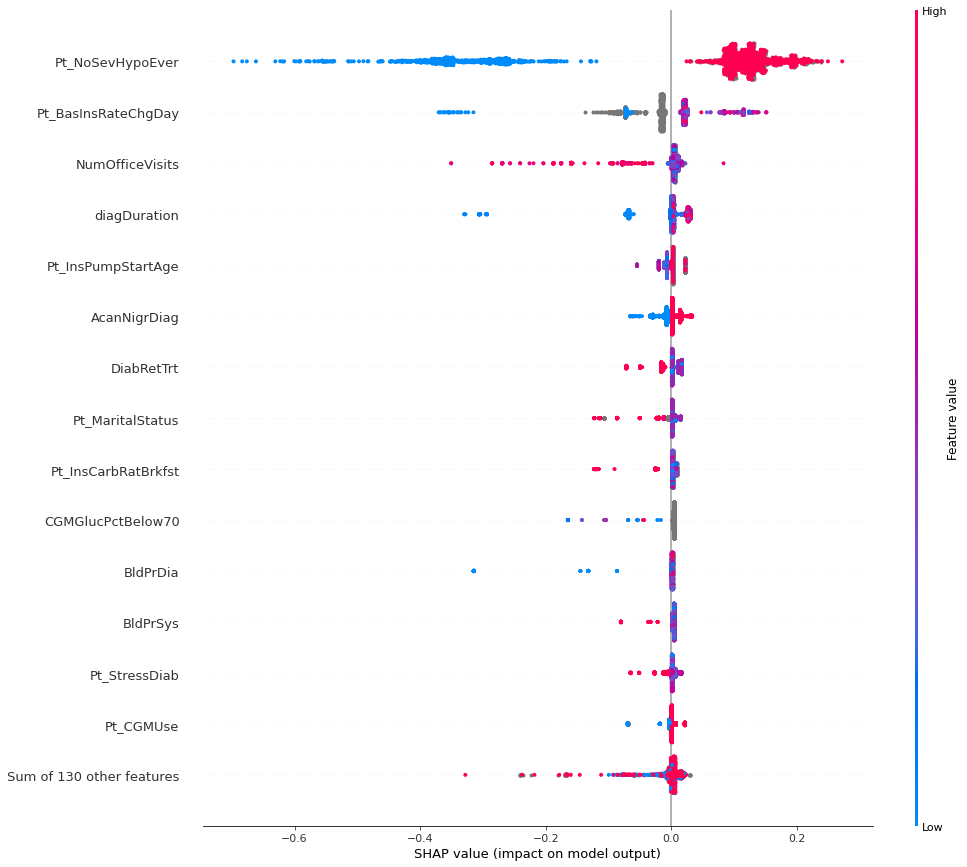

In [42]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_copy)
shap_values = explainer(X_train_copy)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, max_display=15, show=False, plot_size=[15,15])
plt.savefig('SHmaleBeeswarm.png' ,bbox_inches='tight')
pl.show()



In [38]:

pred = model.predict_proba(X_train_copy)[:,1] 
Y_train = pd.DataFrame(Y_train)
X_beeswarm = X_train_copy.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y_train
X_beeswarm['Y'] = Y_train[y_label].to_list()




In [39]:


idx = np.where((X_beeswarm['pred']>thresh2) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(model, X_beeswarm)
shap_values = explainer(X_beeswarm)

(array([  40,  179,  183,  192,  224,  288,  334,  338,  348,  402,  413,
        425,  431,  433,  508,  550,  713,  722,  744,  760,  785,  804,
        836,  840,  843,  858,  868,  874,  883,  896,  903,  939,  988,
       1018, 1029, 1034, 1041, 1113, 1135, 1136, 1161, 1180, 1226, 1243,
       1244, 1332, 1339, 1395, 1558, 1601, 1627, 1674, 1742, 1754, 1774,
       1827, 1835, 1837, 1920, 1922, 1999, 2008, 2067, 2078, 2079, 2145,
       2162, 2253, 2255]),)
(array([], dtype=int64),)
(array([], dtype=int64),)


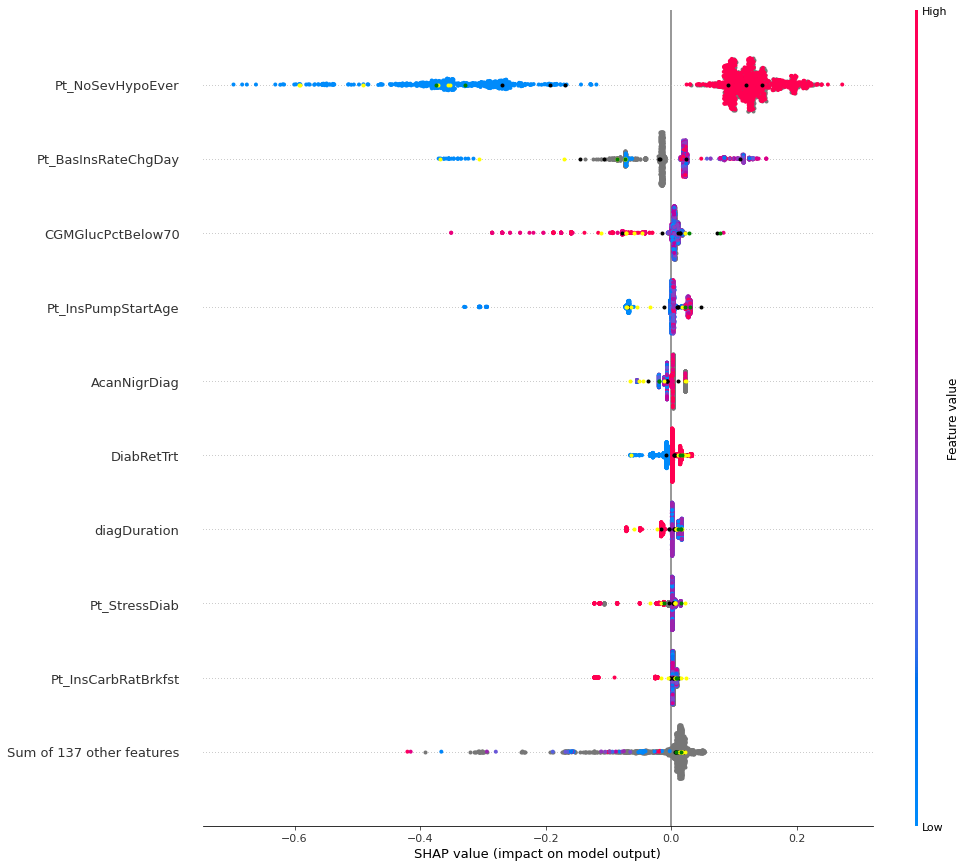

In [40]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[402:403:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[760:761:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[840:841:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1243:1244:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1395:1396:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1558:1559:], show=False, color="black", plot_size=[15,15])


shap.plots.beeswarm(shap_values[179:180:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[192:193:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[334:335:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[348:349:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[413:414:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[425:426:], show=False, color="yellow", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1427:1428:], show=False, color="green", plot_size=[15,15])
shap.plots.beeswarm(shap_values[2212:2213:], show=False, color="green", plot_size=[15,15])


plt.show()

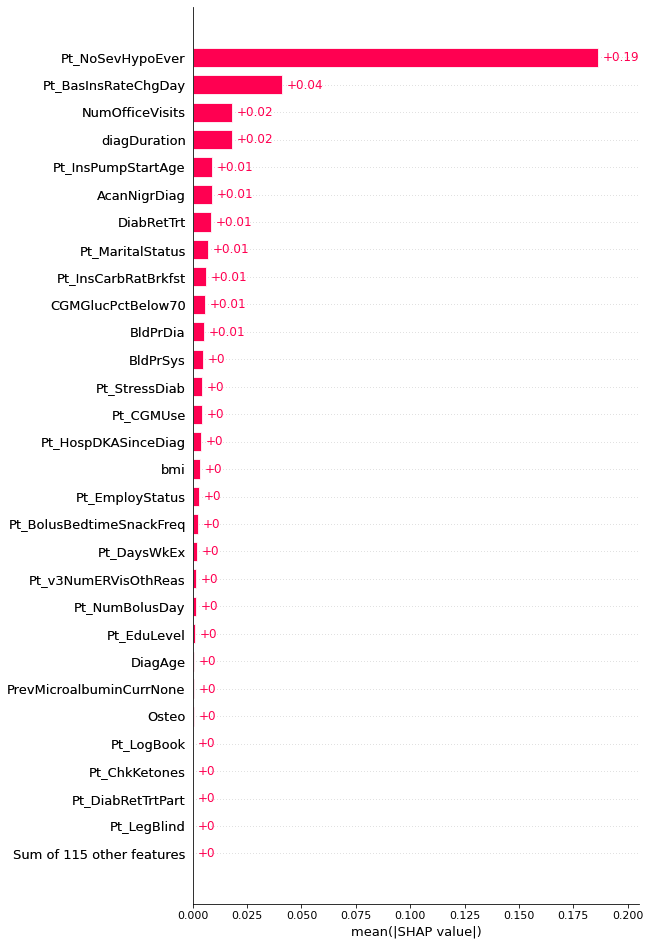

In [41]:
explainer = shap.TreeExplainer(model, X_train_copy)
shap_values = explainer(X_train_copy)
shap.plots.bar(shap_values, max_display=30)
# plt.savefig('fiSHMale.png')

In [42]:
if is_male:
    
    X_train.update(X_train[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))

    X_test.update(X_test[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))

else:
    X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))

    X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))


In [43]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')


imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)

In [44]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [45]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [46]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
# select[0] = pd.DataFrame(scaler.fit_transform(X_train))
# select[1] = Y_train
# select[2] = pd.DataFrame(scaler.transform(X_test))

select[0] = pd.DataFrame(X_train)
select[1] = Y_train
select[2] = pd.DataFrame(X_test)

## Feature Selection

In [47]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [48]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])

    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [49]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[04:47:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA',
       'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay',
       'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk',
       ...
       'AtrialFib', 'CardiacArrhyth', 'Hemoglob', 'RheumArth', 'Osteo',
       'Depression', 'Anxiety', 'Psychosis', 'DiabNeuro', 'diagDuration'],
      dtype='object', length=146)
(3038, 146)


In [51]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [52]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [53]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



In [54]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
#     optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    plt.show()
    return optimal_threshold

In [55]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('balanced accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))    

Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

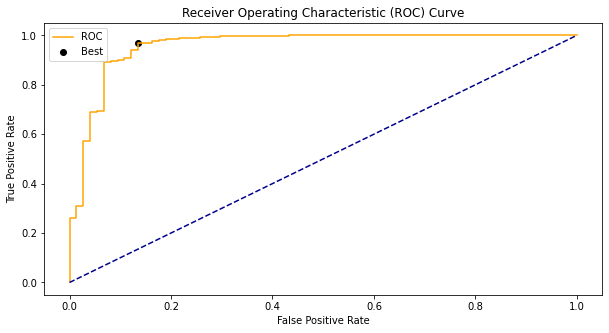

Test ROC
0.8516734693877551
Threshold value is: 0.9602531585200029


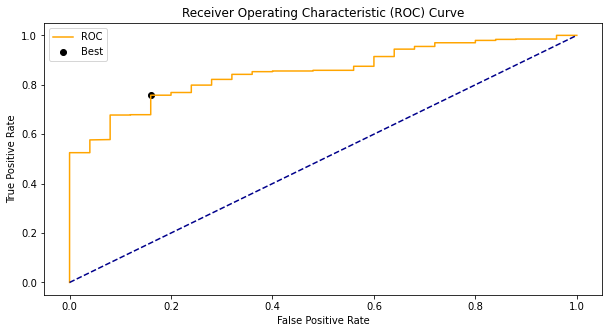


 
 =====================   Train Dataset    ======================
96.6198419666374
              precision    recall  f1-score   support

         0.0       0.49      0.86      0.62        74
         1.0       1.00      0.97      0.98      2204

    accuracy                           0.97      2278
   macro avg       0.74      0.92      0.80      2278
weighted avg       0.98      0.97      0.97      2278



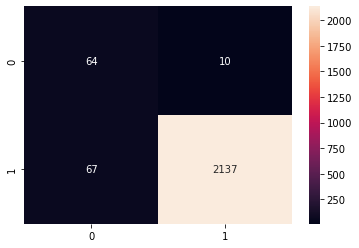



 =====================   Test Dataset    =======================
76.05263157894737
              precision    recall  f1-score   support

         0.0       0.11      0.84      0.19        25
         1.0       0.99      0.76      0.86       735

    accuracy                           0.76       760
   macro avg       0.55      0.80      0.52       760
weighted avg       0.96      0.76      0.84       760



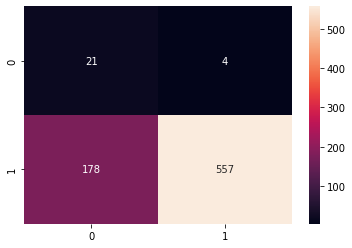



 =======================   Test-ROC    =========================
roc_auc = 0.8517


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.84       0.75782313]
balanced accuracy:  0.7989115646258503
f1 0.7605263157894737


In [56]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01,
                         max_depth =4, random_state=0)
ltb_model = cross_val(ltb_model, 10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

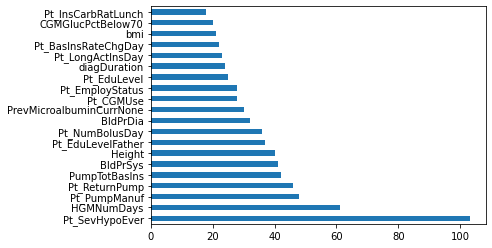

In [57]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

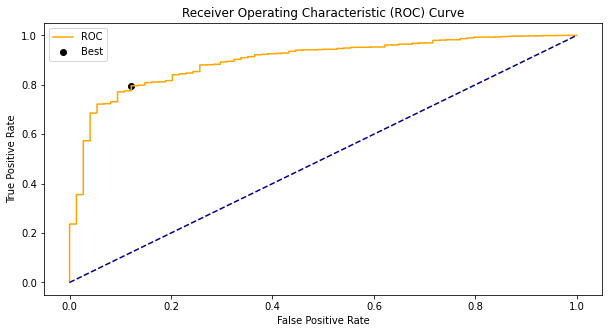

Test ROC
0.8026122448979592
Threshold value is: 0.6108867095454205


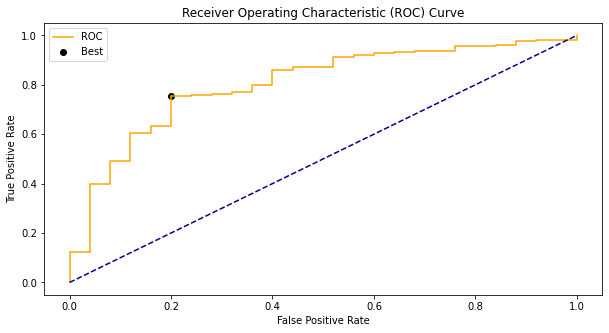


 
 =====================   Train Dataset    ======================
79.8507462686567
              precision    recall  f1-score   support

         0.0       0.13      0.88      0.22        74
         1.0       0.99      0.80      0.88      2204

    accuracy                           0.80      2278
   macro avg       0.56      0.84      0.55      2278
weighted avg       0.97      0.80      0.86      2278



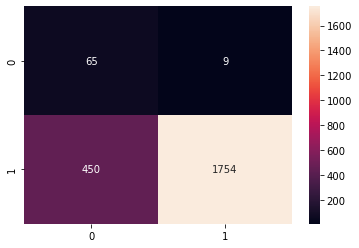



 =====================   Test Dataset    =======================
75.52631578947368
              precision    recall  f1-score   support

         0.0       0.10      0.80      0.18        25
         1.0       0.99      0.75      0.86       735

    accuracy                           0.76       760
   macro avg       0.55      0.78      0.52       760
weighted avg       0.96      0.76      0.83       760



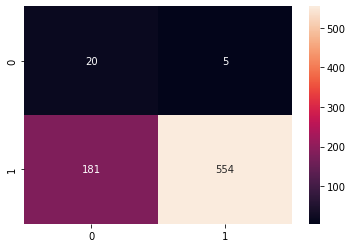



 =======================   Test-ROC    =========================
roc_auc = 0.8026


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8       0.7537415]
balanced accuracy:  0.7768707482993198
f1 0.7552631578947367


In [58]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.008,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

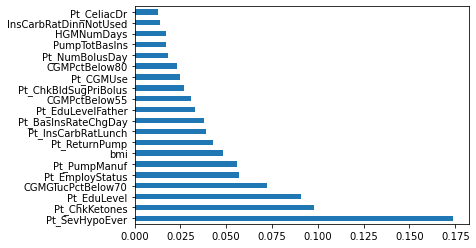

In [59]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

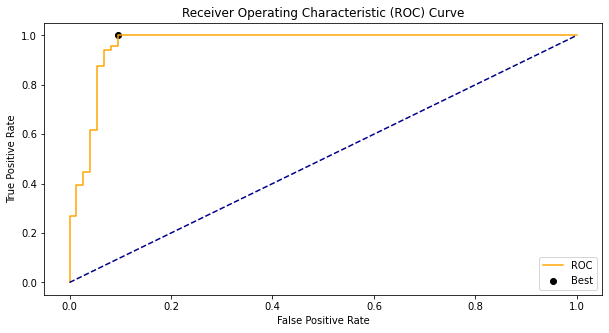

Test ROC
0.8441904761904762
Threshold value is: 3.0247219


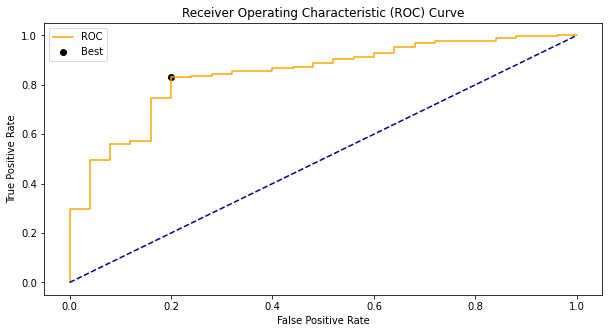


 
 =====================   Train Dataset    ======================
99.69271290605795
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        74
         1.0       1.00      1.00      1.00      2204

    accuracy                           1.00      2278
   macro avg       1.00      0.95      0.97      2278
weighted avg       1.00      1.00      1.00      2278



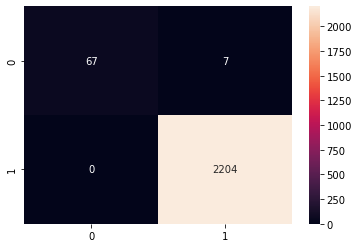



 =====================   Test Dataset    =======================
83.15789473684211
              precision    recall  f1-score   support

         0.0       0.14      0.80      0.24        25
         1.0       0.99      0.83      0.91       735

    accuracy                           0.83       760
   macro avg       0.57      0.82      0.57       760
weighted avg       0.96      0.83      0.88       760



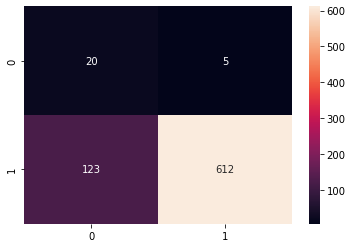



 =======================   Test-ROC    =========================
roc_auc = 0.8442


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.83265306]
balanced accuracy:  0.8163265306122449
f1 0.8315789473684211


In [60]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 6, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

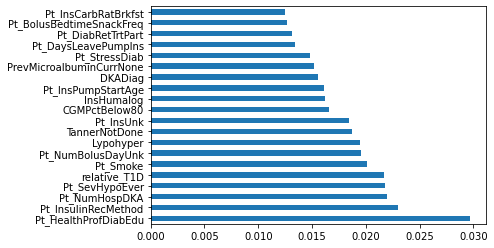

In [61]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.9429824561403509, doublecheck: 0.9429824561403509
Accuracy for the fold no. 2 on the test set: 0.9605263157894737, doublecheck: 0.9605263157894737
Accuracy for the fold no. 3 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9385964912280702, doublecheck: 0.9385964912280702
Accuracy for the fold no. 6 on the test set: 0.9605263157894737, doublecheck: 0.9605263157894737
Accuracy for the fold no. 7 on the test set: 0.956140350877193, doublecheck: 0.956140350877193
Accuracy for the fold no. 8 on the test set: 0.956140350877193, doublecheck: 0.956140350877193
Accuracy for the fold no. 9 on the test set: 0.960352422907489, doublecheck: 0.960352422907489
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accuracy 0.95

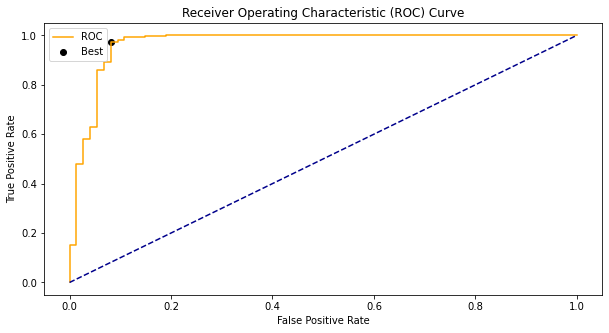

Test ROC
0.8328163265306122
Threshold value is: 0.6602681778245681


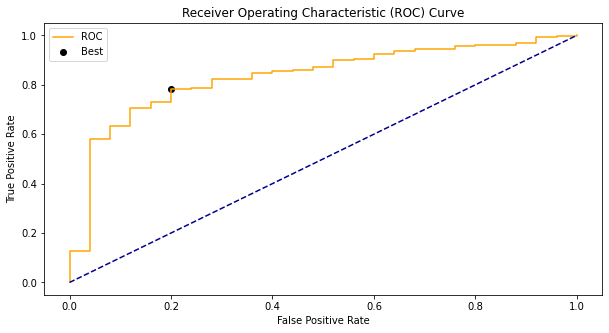


 
 =====================   Train Dataset    ======================
96.97102721685688
              precision    recall  f1-score   support

         0.0       0.52      0.92      0.66        74
         1.0       1.00      0.97      0.98      2204

    accuracy                           0.97      2278
   macro avg       0.76      0.95      0.82      2278
weighted avg       0.98      0.97      0.97      2278



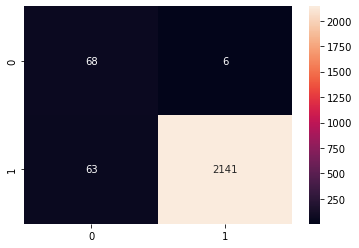



 =====================   Test Dataset    =======================
78.28947368421053
              precision    recall  f1-score   support

         0.0       0.11      0.80      0.20        25
         1.0       0.99      0.78      0.87       735

    accuracy                           0.78       760
   macro avg       0.55      0.79      0.53       760
weighted avg       0.96      0.78      0.85       760



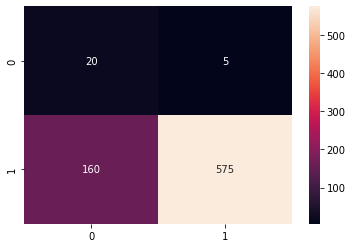



 =======================   Test-ROC    =========================
roc_auc = 0.8328


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.78231293]
balanced accuracy:  0.791156462585034
f1 0.7828947368421053


In [62]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=5,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

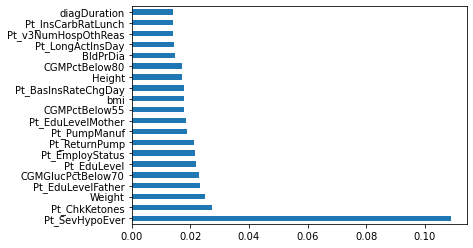

In [63]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

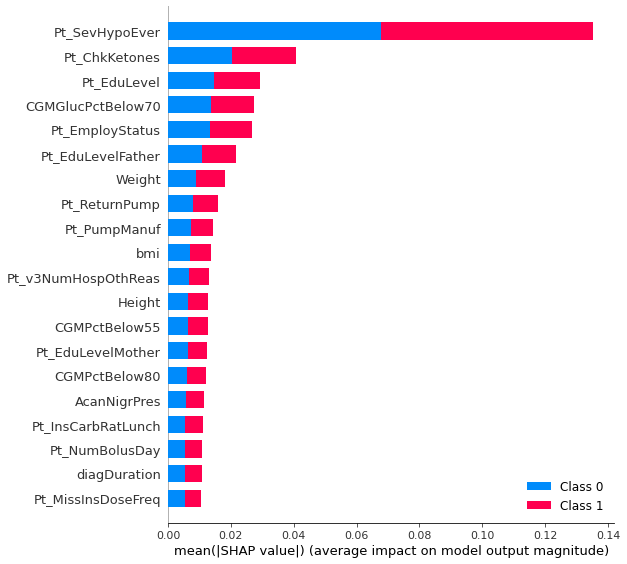

In [64]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.6578947368421053, doublecheck: 0.6578947368421053


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 2 on the test set: 0.5175438596491229, doublecheck: 0.5175438596491229


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.6929824561403509, doublecheck: 0.6929824561403509


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 4 on the test set: 0.7543859649122807, doublecheck: 0.7543859649122807


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.9473684210526315, doublecheck: 0.9473684210526315


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 6 on the test set: 0.6622807017543859, doublecheck: 0.6622807017543859


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.03508771929824561, doublecheck: 0.03508771929824561


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 8 on the test set: 0.618421052631579, doublecheck: 0.618421052631579


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 9 on the test set: 0.6475770925110133, doublecheck: 0.6475770925110133
Accuracy for the fold no. 10 on the test set: 0.762114537444934, doublecheck: 0.762114537444934
Cross validation mean accuracy 0.629565654223665
Train ROC
0.8134105066954432
Threshold value is: 0.6111975726026594


The max_iter was reached which means the coef_ did not converge


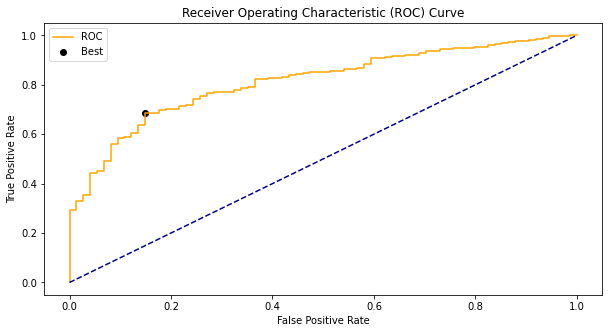

Test ROC
0.6351564625850339
Threshold value is: 0.6583725856741655


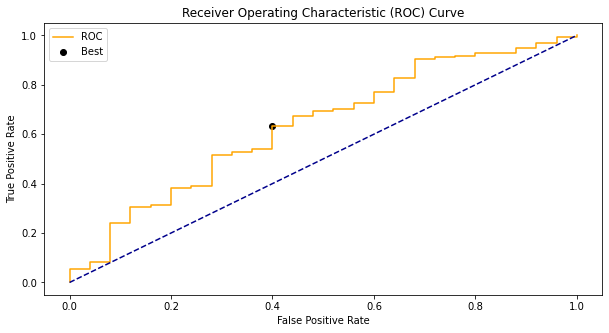


 
 =====================   Train Dataset    ======================
69.00790166812993
              precision    recall  f1-score   support

         0.0       0.08      0.85      0.15        74
         1.0       0.99      0.68      0.81      2204

    accuracy                           0.69      2278
   macro avg       0.54      0.77      0.48      2278
weighted avg       0.96      0.69      0.79      2278



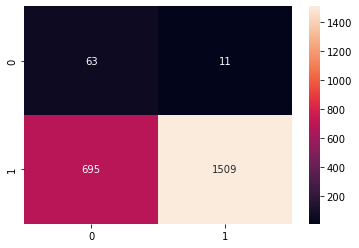



 =====================   Test Dataset    =======================
63.1578947368421
              precision    recall  f1-score   support

         0.0       0.05      0.60      0.10        25
         1.0       0.98      0.63      0.77       735

    accuracy                           0.63       760
   macro avg       0.52      0.62      0.43       760
weighted avg       0.95      0.63      0.75       760



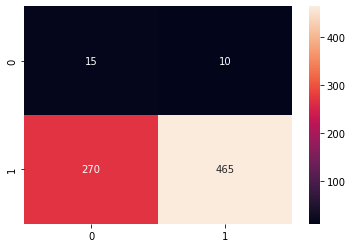



 =======================   Test-ROC    =========================
roc_auc = 0.6352


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.6        0.63265306]
balanced accuracy:  0.616326530612245
f1 0.631578947368421


In [65]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

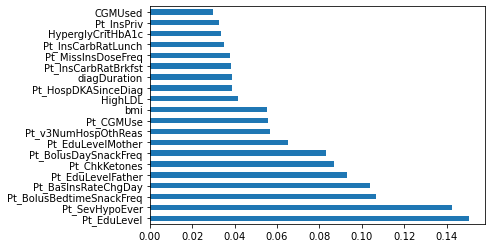

In [66]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9517543859649122, doublecheck: 0.9517543859649122
Accuracy for the fold no. 2 on the test set: 0.9429824561403509, doublecheck: 0.9429824561403509
Accuracy for the fold no. 3 on the test set: 0.9605263157894737, doublecheck: 0.9605263157894737
Accuracy for the fold no. 4 on the test set: 0.9385964912280702, doublecheck: 0.9385964912280702
Accuracy for the fold no. 5 on the test set: 0.9517543859649122, doublecheck: 0.9517543859649122
Accuracy for the fold no. 6 on the test set: 0.9605263157894737, doublecheck: 0.9605263157894737
Accuracy for the fold no. 7 on the test set: 0.9605263157894737, doublecheck: 0.9605263157894737
Accuracy for the fold no. 8 on the test set: 0.9517543859649122, doublecheck: 0.9517543859649122
Accuracy for the fold no. 9 on the test set: 0.9515418502202643, doublecheck: 0.9515418502202643
Accuracy for the fold no. 10 on the test set: 0.9647577092511013, doublecheck: 0.9647577092511013
Cross validation mean accurac

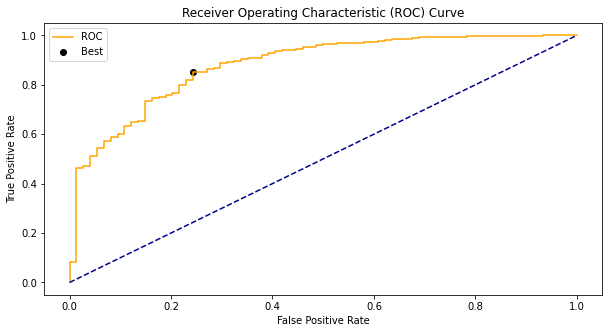

Test ROC
0.6669387755102041
Threshold value is: 0.9947927299579294


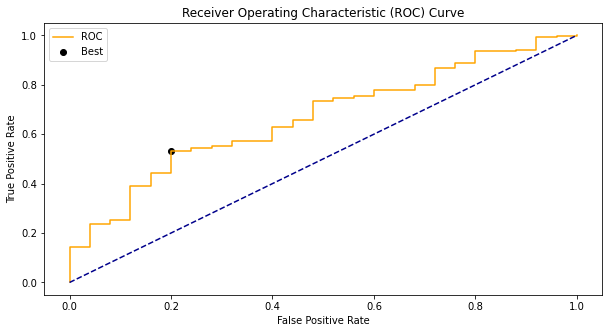


 
 =====================   Train Dataset    ======================
84.72344161545216
              precision    recall  f1-score   support

         0.0       0.15      0.76      0.24        74
         1.0       0.99      0.85      0.92      2204

    accuracy                           0.85      2278
   macro avg       0.57      0.80      0.58      2278
weighted avg       0.96      0.85      0.89      2278



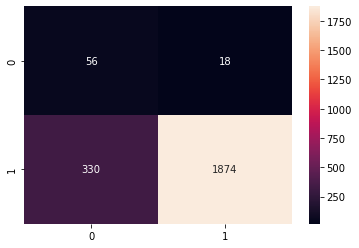



 =====================   Test Dataset    =======================
54.07894736842105
              precision    recall  f1-score   support

         0.0       0.05      0.80      0.10        25
         1.0       0.99      0.53      0.69       735

    accuracy                           0.54       760
   macro avg       0.52      0.67      0.40       760
weighted avg       0.96      0.54      0.67       760



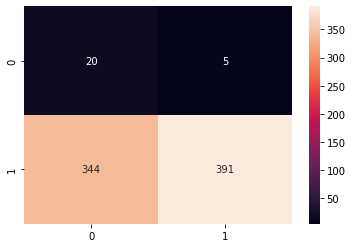



 =======================   Test-ROC    =========================
roc_auc = 0.6669


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.53197279]
balanced accuracy:  0.6659863945578232
f1 0.5407894736842105


In [67]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

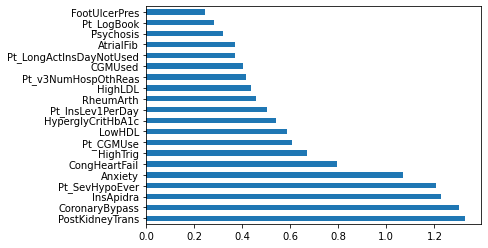

In [68]:


feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

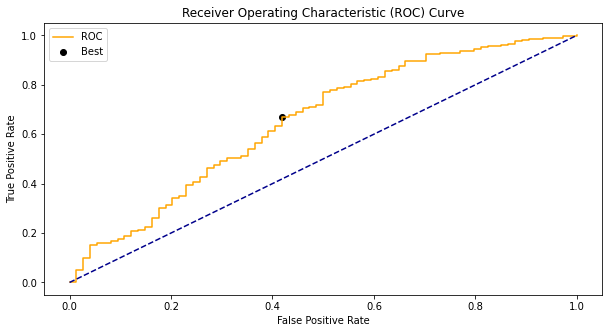

Test ROC
0.5705034013605442
Threshold value is: 0.9696952967433653


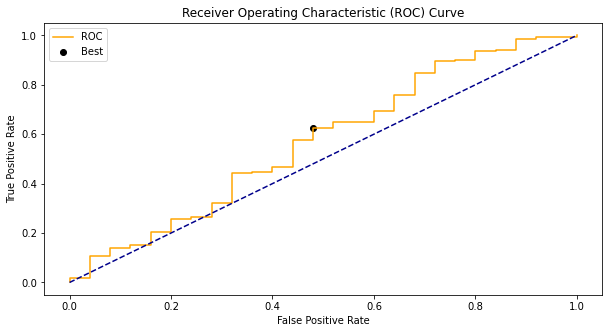


 
 =====================   Train Dataset    ======================
66.85689201053556
              precision    recall  f1-score   support

         0.0       0.06      0.58      0.10        74
         1.0       0.98      0.67      0.80      2204

    accuracy                           0.67      2278
   macro avg       0.52      0.63      0.45      2278
weighted avg       0.95      0.67      0.77      2278



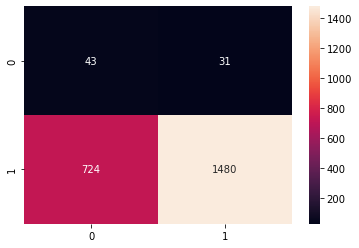



 =====================   Test Dataset    =======================
62.10526315789474
              precision    recall  f1-score   support

         0.0       0.04      0.52      0.08        25
         1.0       0.97      0.62      0.76       735

    accuracy                           0.62       760
   macro avg       0.51      0.57      0.42       760
weighted avg       0.94      0.62      0.74       760



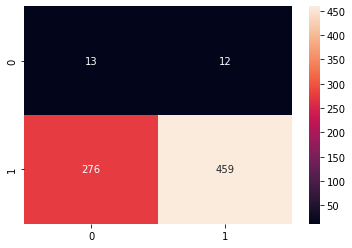



 =======================   Test-ROC    =========================
roc_auc = 0.5705


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.52      0.6244898]
balanced accuracy:  0.5722448979591837
f1 0.6210526315789474


In [69]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

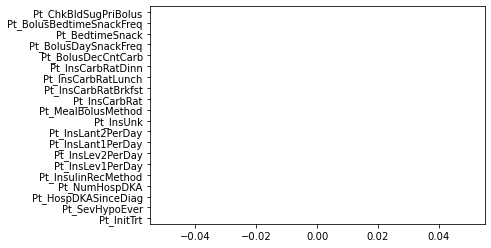

In [70]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')